# Bike Sharing Case Study

In [1]:
# import basic python modules
import numpy as np
import pandas as pd

# import data visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# import scaling library functions
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import data prepration modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# import feature selection algorithms
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# import statsmodel for OLS model
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

#import warnings module
import warnings
warnings.filterwarnings('ignore')

#### Problem Statement
* BoomBikes has a bike-sharing system for use by individuals on short term basis for a price or free.
* Coming out of corona lockdowns, BoomBikes need mindful business plan to be able to accelerate its revenue.
* BoomBikes wants to understand:
    - Which variables are significant in predicting the demand for shared bikes.
    - How well those variables describe the bike demands

In [2]:
# read csv file into a pandas dataframe
bike_rental_df = pd.read_csv('day.csv')

# Data Understanding

In [3]:
bike_rental_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

#### Dataset Characterictics

	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [4]:
bike_rental_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
bike_rental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


* most of the columns in the dataframe dont contain any NULL values

In [6]:
bike_rental_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


* feature instant is nothing but a Sequential Serial Numbering, hence droping it from contention going forward

In [7]:
bike_rental_df.shape

(730, 16)

In [8]:
bike_rental_df['dteday'].value_counts()

01-01-2018    1
25-04-2019    1
27-04-2019    1
28-04-2019    1
29-04-2019    1
             ..
03-09-2018    1
04-09-2018    1
05-09-2018    1
06-09-2018    1
31-12-2019    1
Name: dteday, Length: 730, dtype: int64

* dteday contains 730 unique dates, seems not relevant for us

In [9]:
bike_rental_df['season'].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

* season contains numerical data representing seasons better to have labeled data
* Possible options break it into months for aggregating later based on season

In [10]:
bike_rental_df['mnth'].value_counts()

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

In [11]:
bike_rental_df["weathersit"].value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [12]:
bike_rental_df["weekday"].value_counts()

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

In [13]:
dropped_features = ['instant', 'dteday']
bike_rental_df.drop(columns=dropped_features, axis=1, inplace=True)

In [14]:
bike_rental_df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


In [15]:
#Organising Columns into numeric , categorical and target variable
numeric_features = ['mnth', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
categorical_features = ['yr', 'season', 'holiday', 'weekday', 'wordkingday', 'weathersit']
target_variable = ['cnt']

# Data Visualization

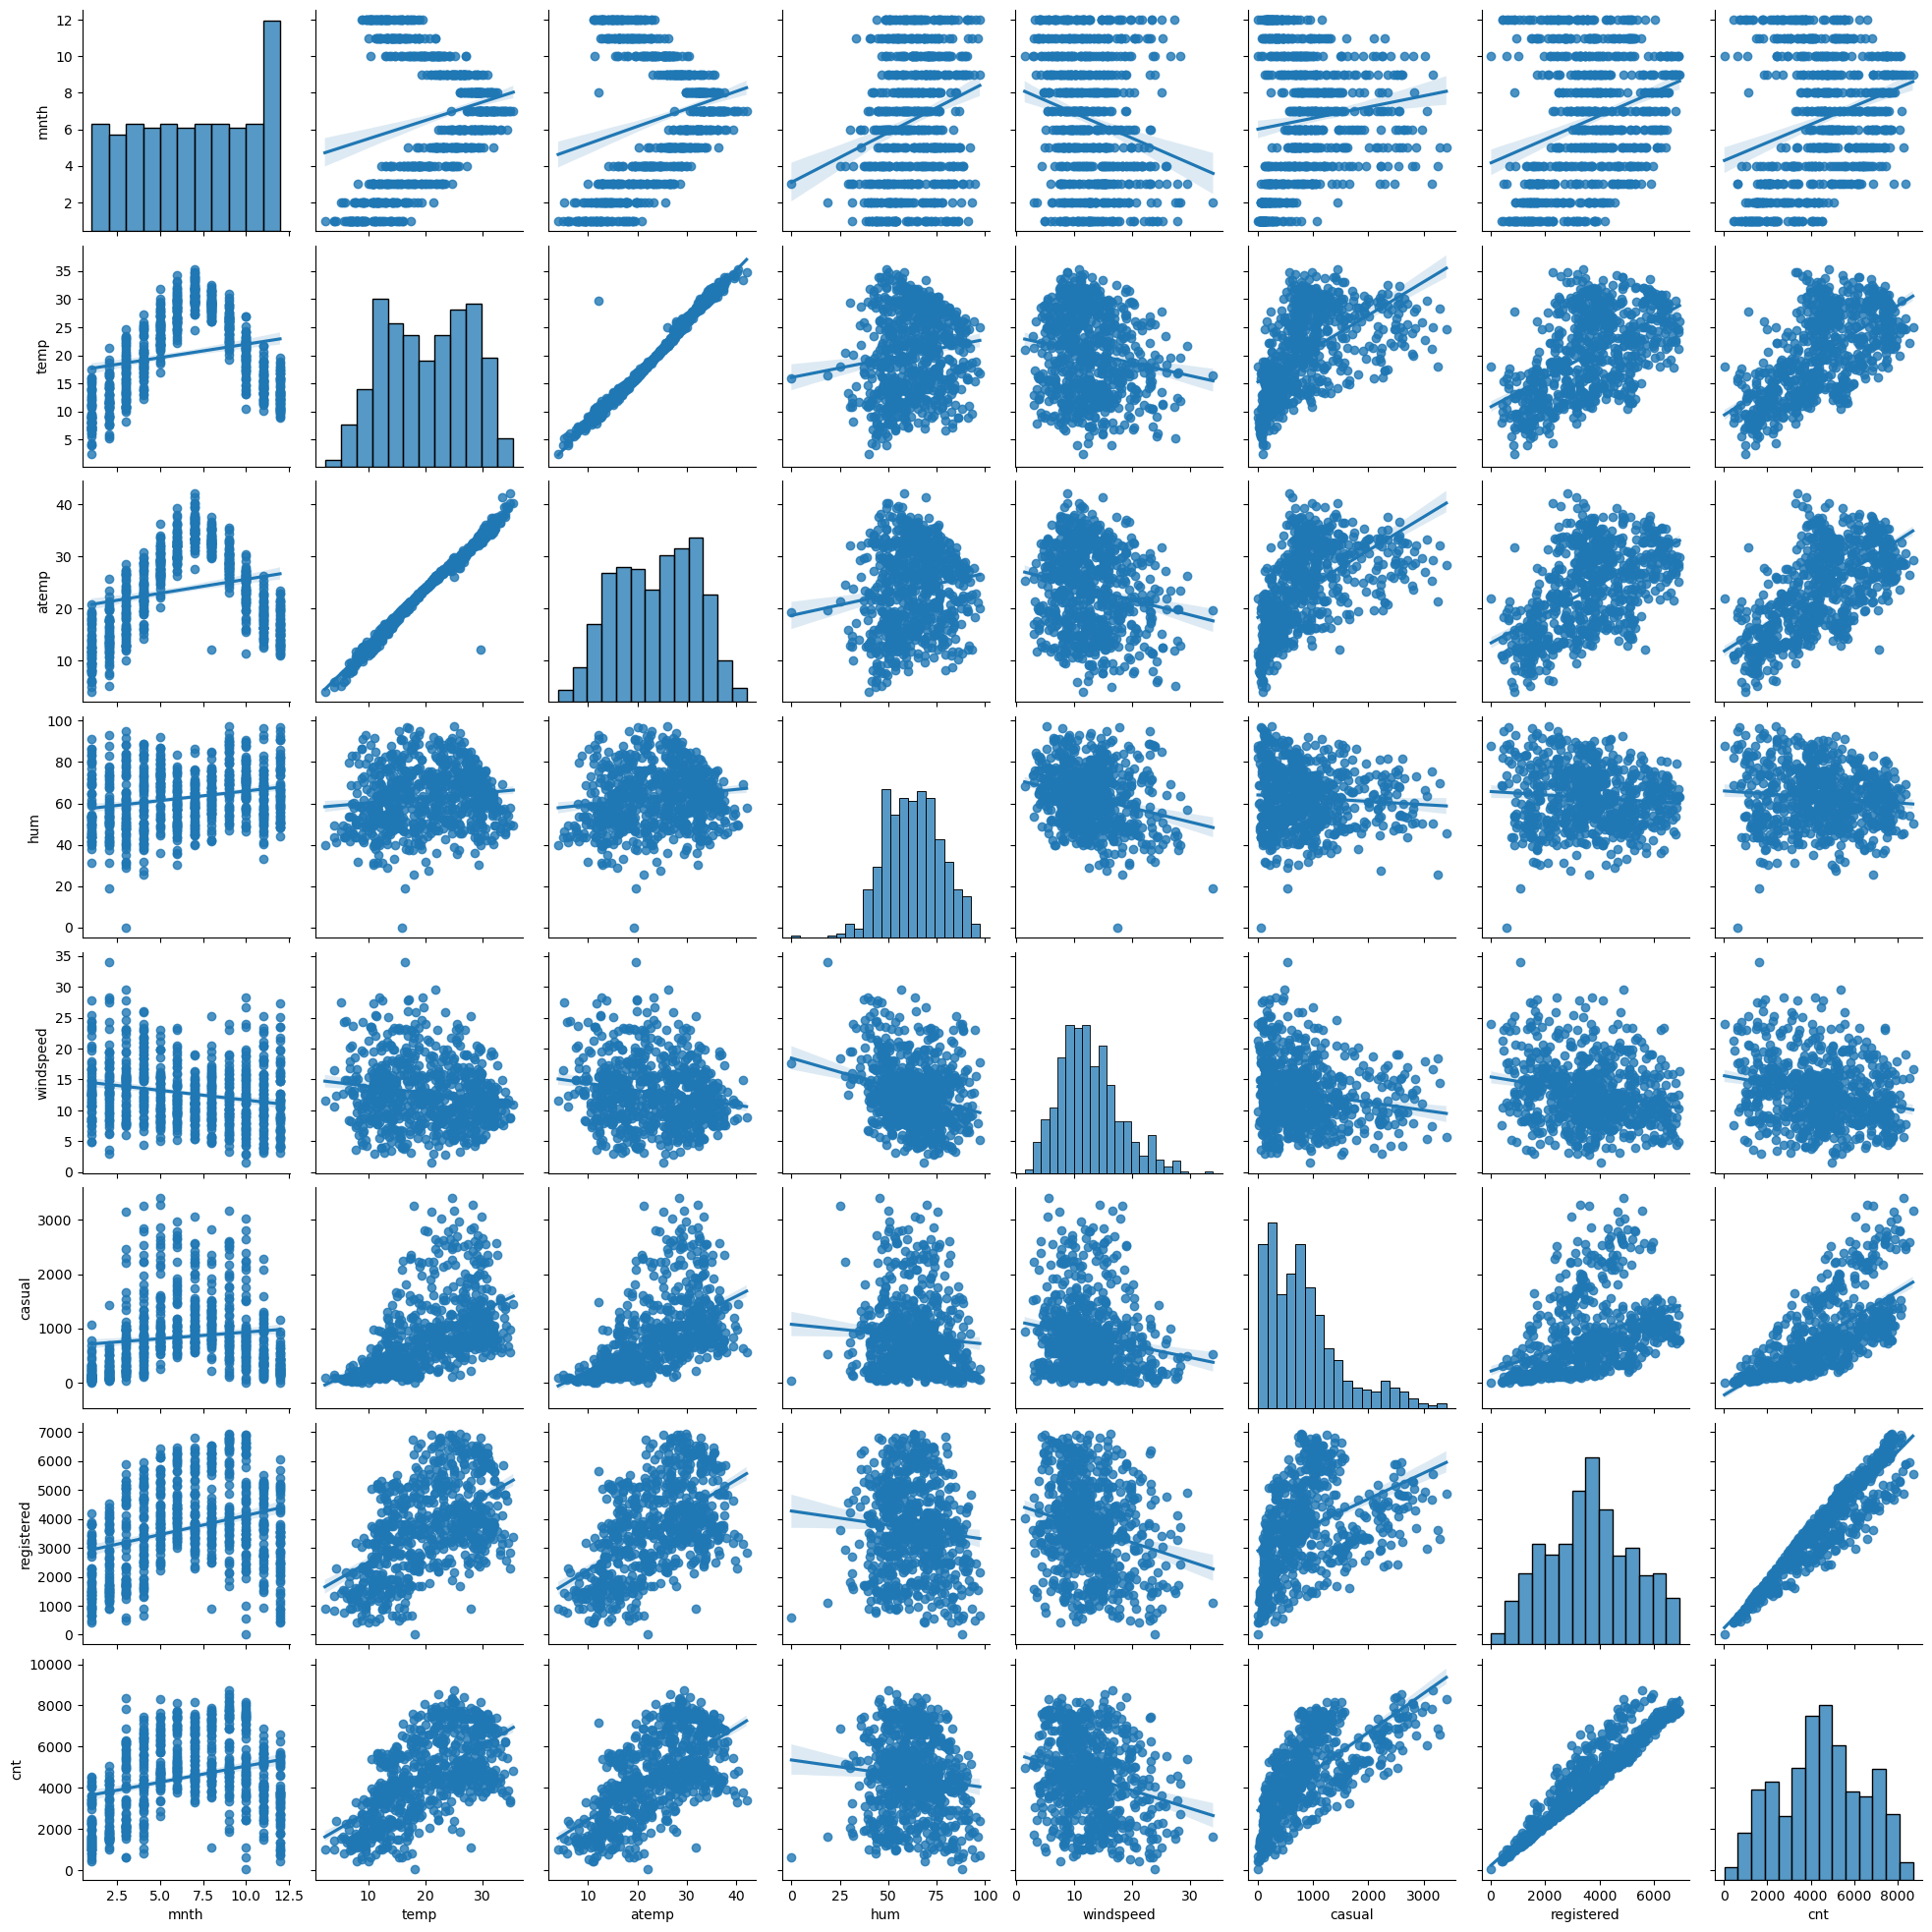

In [16]:
sns.pairplot(bike_rental_df[numeric_features], kind='reg')
plt.show()

Plots with 'registered' , 'casual' and 'mnth' features do not show visible/important trend, analysing without them

In [17]:
numeric_features.remove('mnth')
numeric_features.remove('casual')
numeric_features.remove('registered')

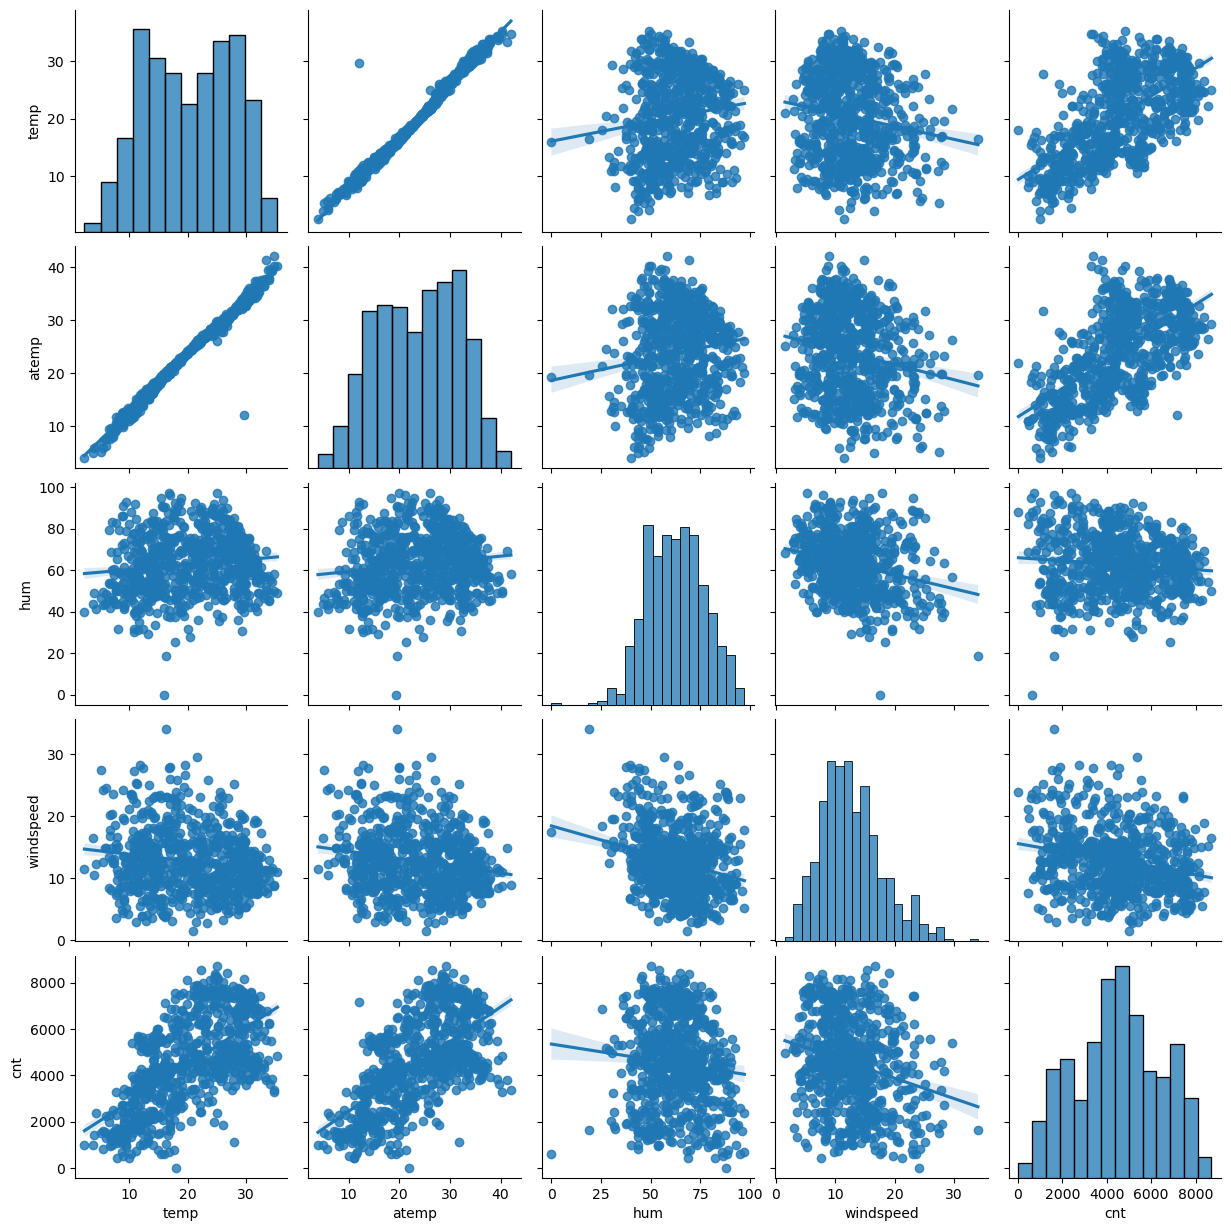

In [18]:
sns.pairplot(bike_rental_df[numeric_features], kind='reg')
plt.show()

Observations-
* features temp to registered does show some linear relation. (with temp and temp showing a greater linear relation)
* month variable pairplot does not show visible relation
* casual and registration indicate mode available to customers to rent a bike and add up to cnt (also mentioned to be dropped)
* instant to be droped

In [19]:
bike_rental_df.drop(labels=['casual', 'registered' ], axis=1, inplace=True)

#### visualizing categorical values

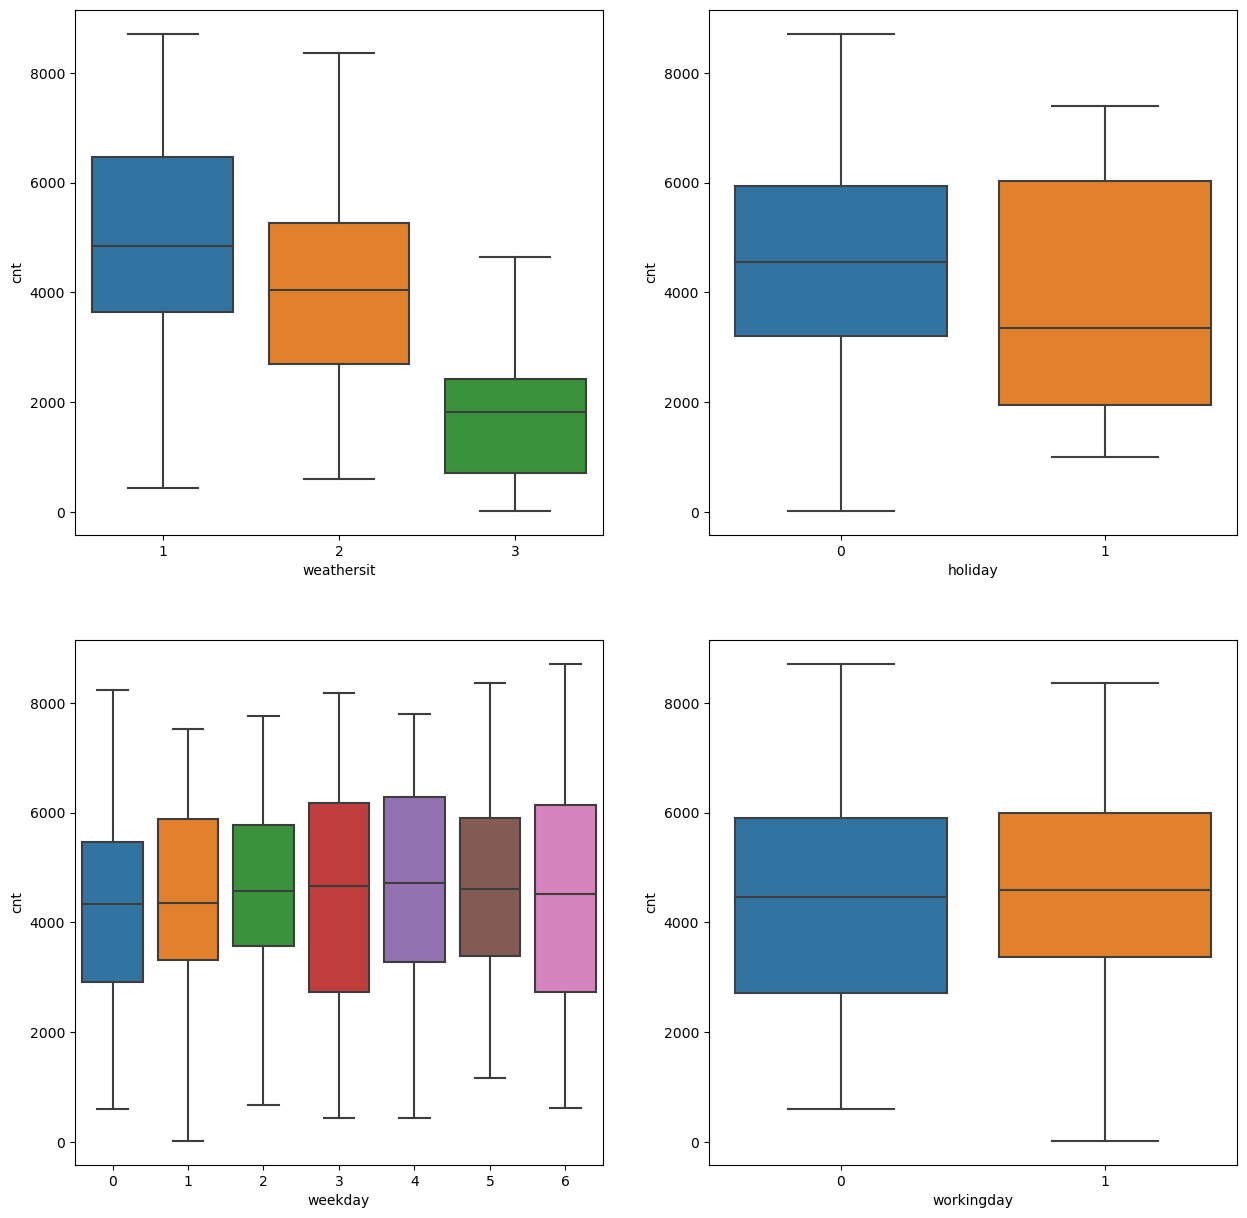

In [20]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
sns.boxplot(data = bike_rental_df, x = 'weathersit', y = 'cnt')


plt.subplot(2,2,2)
sns.boxplot(data = bike_rental_df, x = 'holiday', y = 'cnt')


plt.subplot(2,2,3)
sns.boxplot(data = bike_rental_df, x = 'weekday', y = 'cnt')


plt.subplot(2,2,4)
sns.boxplot(data = bike_rental_df, x = 'workingday', y ='cnt')

plt.show()

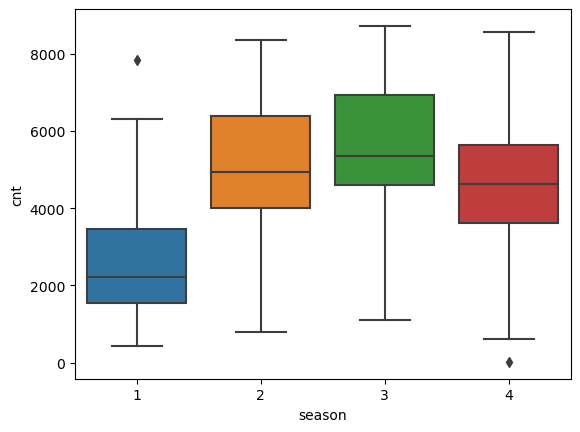

In [21]:
sns.boxplot(data = bike_rental_df, x = 'season', y ='cnt')

plt.show()

seasons summer and fall show more demand for bikes

In [22]:
bike_rental_df[['weathersit','cnt']].groupby('weathersit').describe()

cnt                                                            \
            count         mean          std    min     25%     50%      75%   
weathersit                                                                    
1           463.0  4876.786177  1879.483989  431.0  3636.5  4844.0  6458.50   
2           246.0  4044.813008  1807.309708  605.0  2699.0  4043.0  5258.75   
3            21.0  1803.285714  1240.284449   22.0   705.0  1817.0  2424.00   

                    
               max  
weathersit          
1           8714.0  
2           8362.0  
3           4639.0

The data description of weathersit feature is 
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

looking at the distribuition plots above we can see that number of bike rentals are more with clear/few clouds and go down as weather becomes cloudy, rains and is snowy in nature

weathersit_map = {1: 'clear_parlty_cloudy', 2: 'Cloudy', 3: 'Light_Rain_Snow' , 4: 'Heavy_Rain_Snow' }

In [23]:
bike_rental_df[['holiday','cnt']].groupby('holiday').describe()

cnt                                                                
         count        mean         std     min     25%     50%     75%     max
holiday                                                                       
0        709.0  4530.90268  1927.71680    22.0  3214.0  4563.0  5936.0  8714.0
1         21.0  3735.00000  2103.35066  1000.0  1951.0  3351.0  6034.0  7403.0

In [24]:
bike_rental_df[['holiday','cnt']].groupby('holiday').sum()

,cnt
holiday,
0,3212410
1,78435


* Assuming the mapping {0:'not_a_holiday', 1:'holiday'}
* A general trend non holiday days saw more rental

In [25]:
bike_rental_df[['weekday','cnt']].groupby('weekday').describe()

cnt                                                             \
         count         mean          std     min      25%     50%     75%   
weekday                                                                     
0        105.0  4228.828571  1872.496629   605.0  2918.00  4334.0  5464.0   
1        105.0  4338.123810  1793.074013    22.0  3310.00  4359.0  5875.0   
2        104.0  4510.663462  1826.911642   683.0  3579.25  4576.5  5769.0   
3        103.0  4574.893204  2030.176095   441.0  2731.00  4656.0  6182.5   
4        104.0  4667.259615  1939.433317   431.0  3270.75  4721.0  6286.0   
5        104.0  4690.288462  1874.624870  1167.0  3390.75  4601.5  5900.5   
6        105.0  4550.542857  2196.693009   627.0  2732.00  4521.0  6140.0   

                 
            max  
weekday          
0        8227.0  
1        7525.0  
2        7767.0  
3        8173.0  
4        7804.0  
5        8362.0  
6        8714.0

* Dont see a major difference in trend with respect to renting across weekday

In [26]:
bike_rental_df[['workingday','cnt']].groupby('workingday').describe()

cnt                                                           \
            count         mean          std    min     25%     50%     75%   
workingday                                                                   
0           231.0  4330.168831  2052.141245  605.0  2710.5  4459.0  5907.5   
1           499.0  4590.332665  1876.247607   22.0  3362.0  4585.0  5989.0   

                    
               max  
workingday          
0           8714.0  
1           8362.0

- No major trend here on bike rental across working and non working days
    - an observation is 25 to 50 th percentile more sample points are observed on non working days
    - also the min and max bike rentals are more on non working days

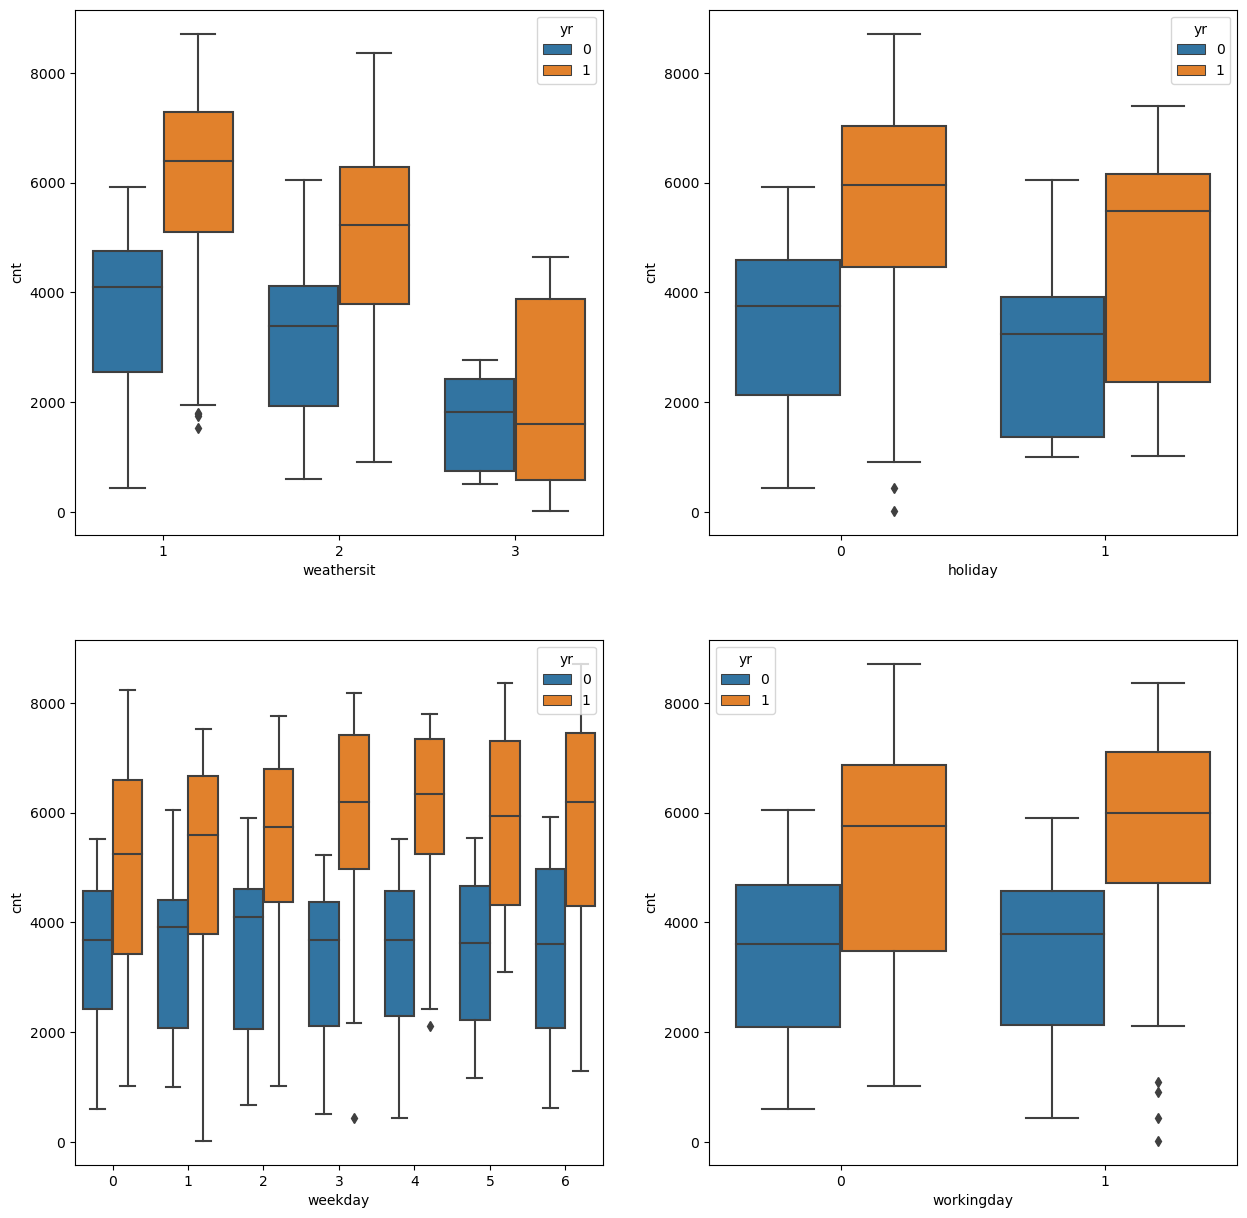

In [27]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
sns.boxplot(data = bike_rental_df, x = 'weathersit', y = 'cnt' , hue = 'yr')


plt.subplot(2,2,2)
sns.boxplot(data = bike_rental_df, x = 'holiday', y = 'cnt', hue = 'yr')


plt.subplot(2,2,3)
sns.boxplot(data = bike_rental_df, x = 'weekday', y = 'cnt', hue = 'yr')


plt.subplot(2,2,4)
sns.boxplot(data = bike_rental_df, x = 'workingday', y = 'cnt', hue = 'yr')

plt.show()

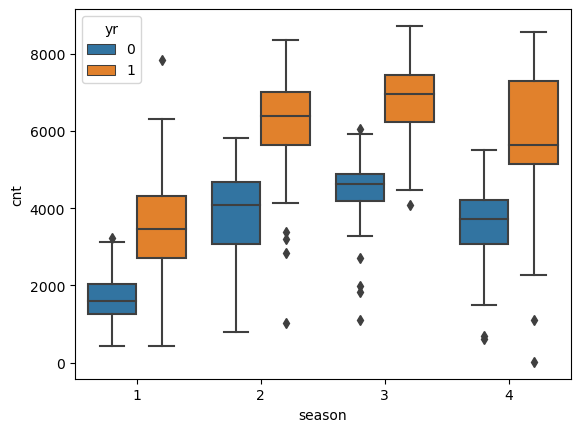

In [28]:
sns.boxplot(data = bike_rental_df, x = 'season', y = 'cnt', hue = 'yr')

plt.show()

summer and fall show more demand for bikes

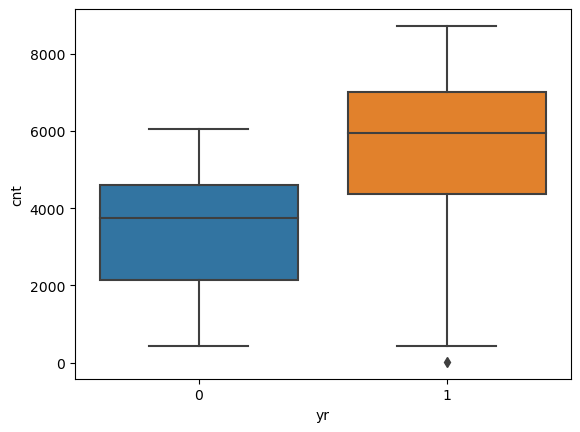

In [29]:
sns.boxplot(data = bike_rental_df, x = 'yr', y = 'cnt')
plt.show()

In [30]:
bike_rental_df[['yr', 'cnt']].groupby(["yr"]).describe()

cnt                                                                 
    count         mean          std    min     25%     50%     75%     max
yr                                                                        
0   365.0  3405.761644  1378.753666  431.0  2132.0  3740.0  4586.0  6043.0
1   365.0  5610.252055  1780.183449   22.0  4375.0  5936.0  7013.0  8714.0

* A general trend from above distribution plots year 2019 saw more usage as compared to 2018

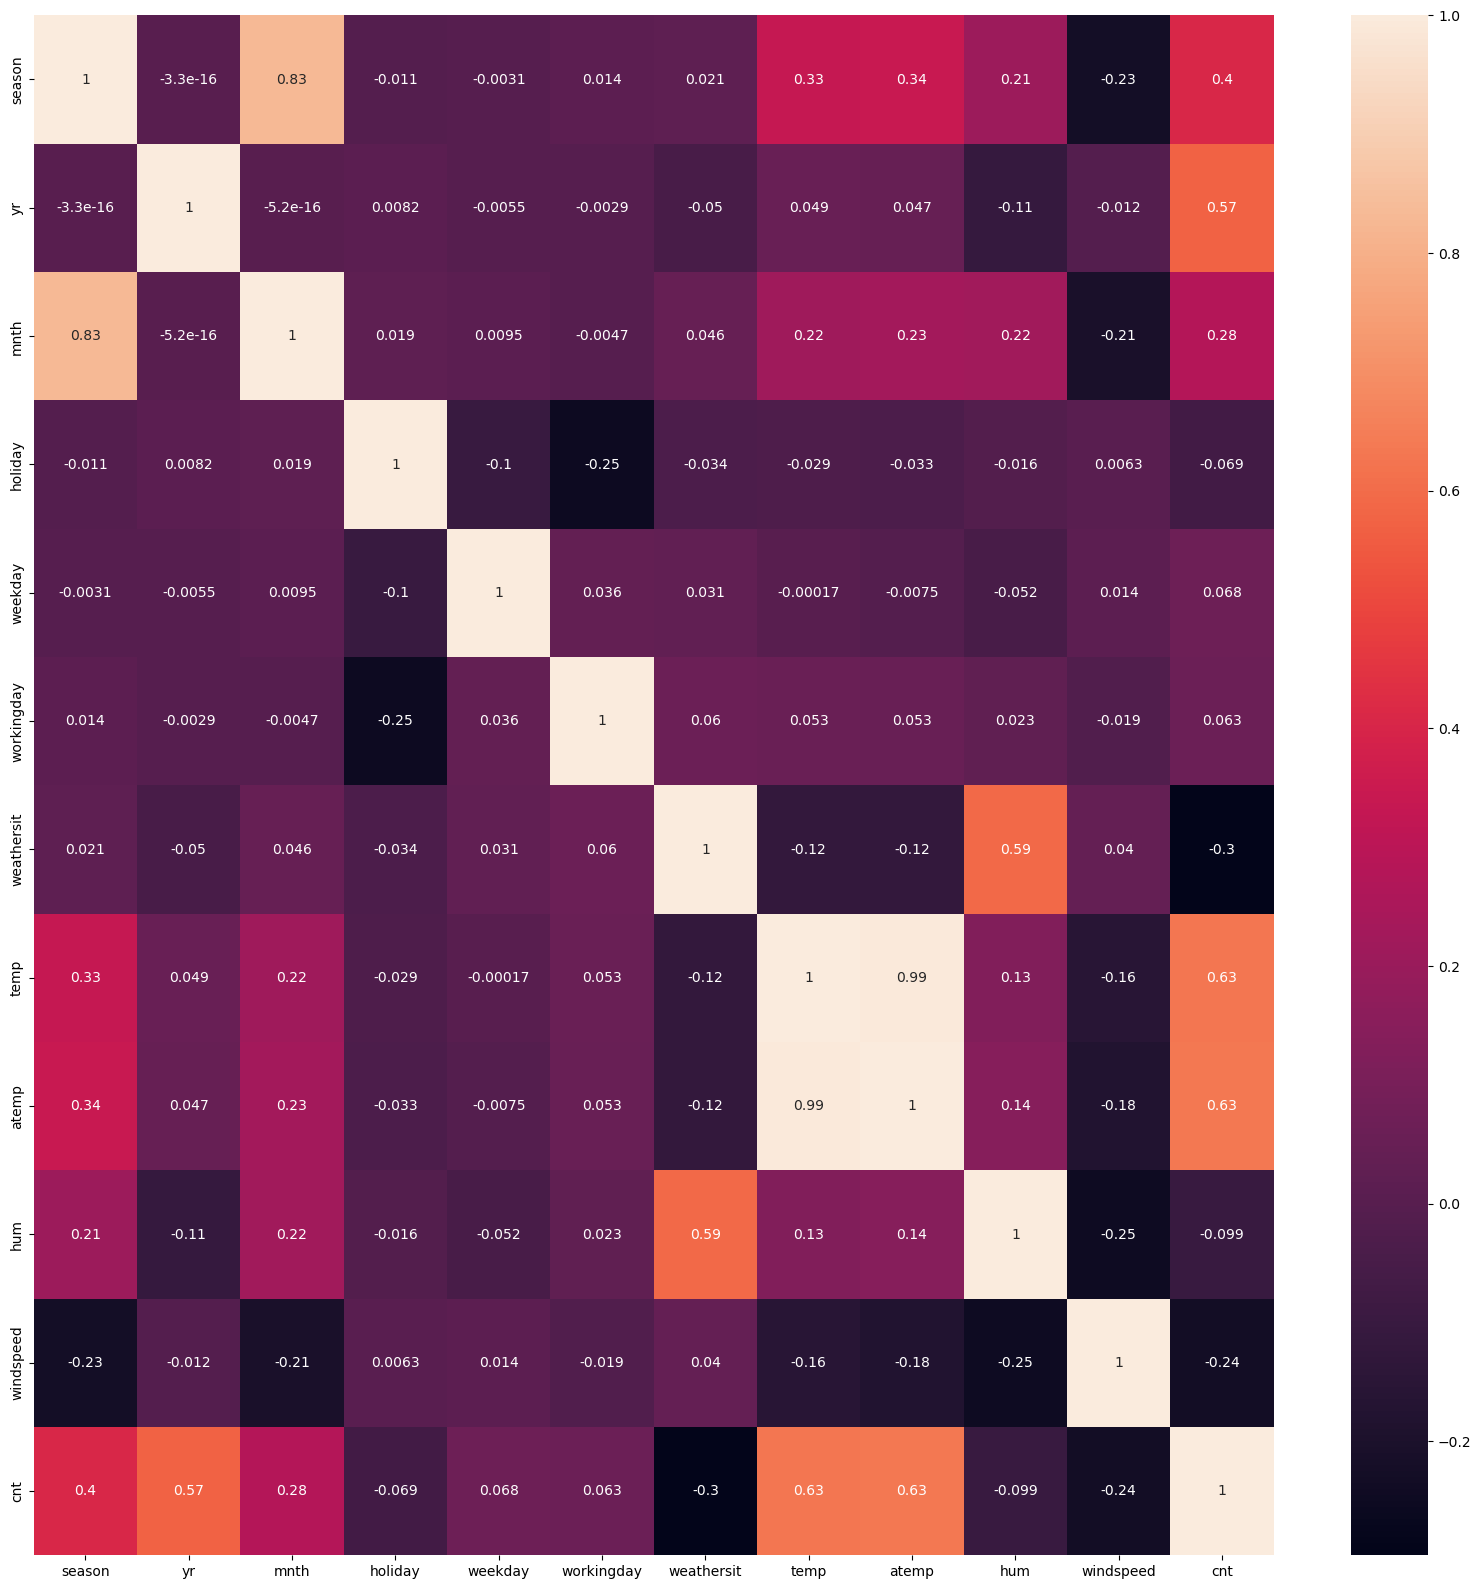

In [31]:
plt.figure(figsize=(20,20))
sns.heatmap(data=bike_rental_df.corr(), annot=True)
plt.show()

* season and month seem to be correlated
* season and temp and atemp are loosely correlated
* weathersit and humidity are correlated
* temp and atemp are highly correlated

## Data Pre-processing

### Mapping Categorical Features

In [32]:
categorical_features = ['yr', 'holiday', 'weekday', 'wordkingday', 'weathersit']
weekday_mapping = {1: 'Wed', 2: 'Thurs', 3: 'Fri', 4: 'Sat', 5: 'Sun', 6: 'Mon', 0: 'Tues'}
weathersit_map = {1: 'clear_parlty_cloudy', 2: 'Cloudy', 3: 'Light_Rain_Snow' , 4: 'Heavy_Rain_Snow' }
season_map = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}

In [33]:
bike_rental_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [34]:
bike_rental_df['season']     = bike_rental_df[['season']].apply(lambda x: x.map(season_map))
bike_rental_df['weathersit'] = bike_rental_df[['weathersit']].apply(lambda x: x.map(weathersit_map))
bike_rental_df['weekday']    = bike_rental_df[['weekday']].apply(lambda x: x.map(weekday_mapping))

In [35]:
bike_rental_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,1,0,Mon,0,Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,1,0,Tues,0,Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,1,0,Wed,1,clear_parlty_cloudy,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,1,0,Thurs,1,clear_parlty_cloudy,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,1,0,Fri,1,clear_parlty_cloudy,9.305237,11.46350,43.6957,12.522300,1600


In [36]:
season_enc = pd.get_dummies(bike_rental_df['season'], drop_first=True)
weathersit_enc = pd.get_dummies(bike_rental_df['weathersit'], drop_first= True)
weekday_enc = pd.get_dummies(bike_rental_df['weekday'], drop_first = True)
bike_rental_df = bike_rental_df.drop(columns=['season', 'weekday', 'weathersit'], axis=1)

In [37]:
reorg_list = ['cnt', 'yr', 'mnth', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']
bike_rental_df = bike_rental_df .reindex(columns=reorg_list)

In [38]:
bike_rental_df = pd.concat([bike_rental_df,season_enc, weekday_enc, weathersit_enc], axis=1)

In [39]:
bike_rental_df

,cnt,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain_Snow,clear_parlty_cloudy
0,985,0,1,0,0,14.110847,18.18125,80.5833,10.749882,1,0,0,1,0,0,0,0,0,0,0
1,801,0,1,0,0,14.902598,17.68695,69.6087,16.652113,1,0,0,0,0,0,0,1,0,0,0
2,1349,0,1,0,1,8.050924,9.47025,43.7273,16.636703,1,0,0,0,0,0,0,0,1,0,1
3,1562,0,1,0,1,8.200000,10.60610,59.0435,10.739832,1,0,0,0,0,0,1,0,0,0,1
4,1600,0,1,0,1,9.305237,11.46350,43.6957,12.522300,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2114,1,12,0,1,10.420847,11.33210,65.2917,23.458911,1,0,0,0,1,0,0,0,0,0,0
726,3095,1,12,0,1,10.386653,12.75230,59.0000,10.416557,1,0,0,0,0,1,0,0,0,0,0
727,1341,1,12,0,0,10.386653,12.12000,75.2917,8.333661,1,0,0,1,0,0,0,0,0,0,0
728,1796,1,12,0,0,10.489153,11.58500,48.3333,23.500518,1,0,0,0,0,0,0,1,0,0,1


## Data Preparation

#### Train Test split and MinMax Scaling the feature dataset

In [40]:
bike_rental_train_df , bike_rental_test_df = train_test_split(bike_rental_df, train_size=0.7, test_size=0.3, random_state=59)

In [41]:
# set up minMax scaler for numeric features
scaler = MinMaxScaler(copy=False)
scaled_cols = ["cnt", 'mnth', "temp", "atemp", "hum", "windspeed"]

In [42]:
# minMax transformation of numeric features
bike_rental_train_df[scaled_cols] = scaler.fit_transform(bike_rental_train_df[scaled_cols])
bike_rental_test_df[scaled_cols] = scaler.fit_transform(bike_rental_test_df[scaled_cols])

In [43]:
bike_rental_train_df.head()

,cnt,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain_Snow,clear_parlty_cloudy
649,0.843304,1,0.818182,0,1,0.471467,0.473706,0.554413,0.482864,0,0,1,0,0,1,0,0,0,0,1
547,0.713442,1,0.545455,0,1,0.900316,0.833624,0.459725,0.383117,0,0,0,0,0,0,0,0,1,0,1
156,0.506770,0,0.454545,0,1,0.771557,0.726331,0.616967,0.199349,0,1,0,0,0,0,0,0,1,0,1
93,0.330379,0,0.272727,0,1,0.640722,0.620713,0.438303,0.859760,0,1,0,0,0,0,0,0,1,0,1
376,0.451256,1,0.000000,0,1,0.402934,0.405283,0.825622,0.347301,1,0,0,0,1,0,0,0,0,0,0


In [44]:
bike_rental_test_df.head()

,cnt,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain_Snow,clear_parlty_cloudy
460,0.740681,1,0.272727,0,1,0.399325,0.391091,0.248358,0.573104,0,1,0,0,0,1,0,0,0,0,1
357,0.113783,0,1.000000,0,0,0.263217,0.267281,0.465536,0.346160,1,0,0,1,0,0,0,0,0,0,1
234,0.675679,0,0.636364,0,1,0.719910,0.682336,0.351204,0.256398,0,0,0,0,0,0,1,0,0,0,1
278,0.545674,0,0.818182,0,1,0.521935,0.512375,0.568380,0.232053,0,0,1,0,1,0,0,0,0,0,1
434,0.562471,1,0.181818,0,0,0.343180,0.349024,0.379484,0.412713,1,0,0,0,0,0,0,1,0,0,1


# Feature Selection/Elimination

Criterion for eliminating a feature
- stratigforward low p value - low vif (the prdictor is significant)

- both high (p-value and vif) and remove

- High-low Value Problem
    - High p vs Low Vif -> remove first
    - Low p vs High Vif -> remove these after once above

- VIF > 5 typically remove

### Manual Feature Selection/Elimination

In [45]:
# we extract the train vectors and target variable
y_train = bike_rental_train_df.pop('cnt')
X_train = bike_rental_train_df

In [46]:
# set up a stats model
X_train_sm = sm.add_constant(X_train)
sm_mlr_1 = sm.OLS(y_train, X_train_sm)
ols_1 = sm_mlr_1.fit()

In [47]:
ols_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     142.6
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          9.23e-182
Time:                        20:28:24   Log-Likelihood:                 480.70
No. Observations:                 510   AIC:                            -923.4
Df Residuals:                     491   BIC:                            -842.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1032      0.035      2.984      0.003       0.035       0.171
yr                      0.2543      0.009     29.045      0.000       0.237       0.272
mnth                    0.0233      0.027      0.857      0.392      -0.030       0.077
holiday                -0.0191      0.025     -0.768      0.443      -0.068       0.030
workingday              0.0516      0.013      4.041      0.000       0.026       0.077
temp                    0.4187      0.141      2.977      0.003       0.142       0.695
atemp                   0.0936      0.142      0.658      0.511      -0.186       0.373
hum                    -0.1003      0.040     -2.536      0.012      -0.178      -0.023
windspeed              -0.1162      0.025     -4.716      0.000      -0.165      -0.068
spring                 -0.0828      0.023     -3.527      0.000      -0.129      -0.037
summer                  0.0402      0.016      2.493      0.013       0.009       0.072
winter                  0.0845      0.018      4.573      0.000       0.048       0.121
Mon                     0.0640      0.014      4.573      0.000       0.037       0.091
Sat                     0.0071      0.016      0.454      0.650      -0.024       0.038
Sun                     0.0081      0.016      0.515      0.607      -0.023       0.039
Thurs                  -0.0163      0.016     -1.034      0.301      -0.047       0.015
Tues                    0.0067      0.015      0.458      0.647      -0.022       0.035
Wed                    -0.0137      0.016     -0.849      0.396      -0.045       0.018
Light_Rain_Snow        -0.1791      0.027     -6.756      0.000      -0.231      -0.127
clear_parlty_cloudy     0.0652      0.011      5.783      0.000       0.043       0.087
==============================================================================
Omnibus:                       69.381   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.459
Skew:                          -0.740   Prob(JB):                     7.84e-34
Kurtosis:                       5.232   Cond. No.                     1.64e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.5e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The following columns show high p-value

    * mnth
    * holiday
    * atemp
    * Sat, Sun , Thurs, Tues, Wed 

In [48]:
# compute vif for the feature variables
vif = pd.DataFrame()
vif["predictors"] = X_train.columns
vif["vif"] = [variance_inflation_factor(X_train.values, idx) for idx in range(X_train.shape[1])]
vif["vif"] = round(vif["vif"],2)
vif.sort_values(by="vif", ascending=False)

,predictors,vif
3,workingday,74.14
4,temp,57.02
5,atemp,53.12
11,Mon,14.64
15,Tues,14.10
8,spring,5.53
1,mnth,3.95
2,holiday,3.77
10,winter,3.49
9,summer,2.68


features with VIF > 5

 * workingday
 * temp
 * atemp
 * Mon	
 * Tues	
 * Spring

We remove features one by one and test creating multiple models to check r2 and adjusted r2 score. We arrive at the feature set below to be eliminated based on high pvalue criterion for elimination

In [49]:
#eliminating high pValue features 
high_p_value_columns = ['mnth', 'holiday' ,'atemp', 'Mon', 'Tues', 'Wed', 'Thurs', 'Sat', 'Sun']
feature_columns = list(bike_rental_train_df.columns)
pruned_features = [feature_columns.remove(element) for element in high_p_value_columns if element in list(feature_columns)]

In [50]:
feature_columns

['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'spring',
 'summer',
 'winter',
 'Light_Rain_Snow',
 'clear_parlty_cloudy']

In [51]:
X_train_sm = sm.add_constant(X_train[feature_columns])
sm_mlr_2 = sm.OLS(y_train, X_train_sm)
ols_2 = sm_mlr_2.fit()

In [52]:
ols_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     247.1
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          4.29e-186
Time:                        20:28:39   Log-Likelihood:                 469.15
No. Observations:                 510   AIC:                            -916.3
Df Residuals:                     499   BIC:                            -869.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1524      0.041      3.708      0.000       0.072       0.233
yr                      0.2548      0.009     28.733      0.000       0.237       0.272
workingday              0.0182      0.009      1.920      0.055      -0.000       0.037
temp                    0.5078      0.034     14.904      0.000       0.441       0.575
hum                    -0.1043      0.040     -2.633      0.009      -0.182      -0.026
windspeed              -0.1166      0.025     -4.718      0.000      -0.165      -0.068
spring                 -0.0944      0.021     -4.552      0.000      -0.135      -0.054
summer                  0.0348      0.014      2.460      0.014       0.007       0.063
winter                  0.0912      0.017      5.377      0.000       0.058       0.124
Light_Rain_Snow        -0.1704      0.027     -6.428      0.000      -0.222      -0.118
clear_parlty_cloudy     0.0637      0.011      5.584      0.000       0.041       0.086
==============================================================================
Omnibus:                       62.643   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.414
Skew:                          -0.687   Prob(JB):                     1.76e-29
Kurtosis:                       5.084   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

workingday feature is showing high p value elminiating it

In [53]:
# train a stats ols model
feature_columns.remove('workingday')
X_train_sm = sm.add_constant(X_train[feature_columns])
sm_mlr_3 = sm.OLS(y_train, X_train_sm)
ols_3 = sm_mlr_3.fit()

In [54]:
ols_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     272.7
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          1.57e-186
Time:                        20:28:48   Log-Likelihood:                 467.27
No. Observations:                 510   AIC:                            -914.5
Df Residuals:                     500   BIC:                            -872.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1627      0.041      3.981      0.000       0.082       0.243
yr                      0.2550      0.009     28.687      0.000       0.238       0.272
temp                    0.5120      0.034     15.017      0.000       0.445       0.579
hum                    -0.1045      0.040     -2.631      0.009      -0.183      -0.026
windspeed              -0.1175      0.025     -4.742      0.000      -0.166      -0.069
spring                 -0.0916      0.021     -4.416      0.000      -0.132      -0.051
summer                  0.0367      0.014      2.592      0.010       0.009       0.065
winter                  0.0926      0.017      5.454      0.000       0.059       0.126
Light_Rain_Snow        -0.1699      0.027     -6.392      0.000      -0.222      -0.118
clear_parlty_cloudy     0.0621      0.011      5.447      0.000       0.040       0.085
==============================================================================
Omnibus:                       71.617   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.312
Skew:                          -0.776   Prob(JB):                     1.39e-33
Kurtosis:                       5.171   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
#vif computation
X = X_train[feature_columns]
vif = pd.DataFrame()
vif["predictors"] = X.columns
vif["vif"] = [variance_inflation_factor(X.values, idx) for idx in range(X.shape[1])]
vif["vif"] = round(vif["vif"],2)
vif.sort_values(by="vif", ascending=False)

,predictors,vif
2,hum,19.78
1,temp,16.63
3,windspeed,4.70
4,spring,3.89
8,clear_parlty_cloudy,3.47
6,winter,3.00
5,summer,2.24
0,yr,2.09
7,Light_Rain_Snow,1.18


### We try one by one eliminating high VIF features hum and then temp



In [56]:
#eliminating high VIF features
high_vif_features = ['hum']
pruned_features = [feature_columns.remove(element) for element in high_vif_features if element in list(feature_columns)]
feature_columns

['yr',
 'temp',
 'windspeed',
 'spring',
 'summer',
 'winter',
 'Light_Rain_Snow',
 'clear_parlty_cloudy']

In [57]:
X_train_sm = sm.add_constant(X_train[feature_columns])
sm_mlr_4 = sm.OLS(y_train, X_train_sm)
ols_4 = sm_mlr_4.fit()

In [58]:
ols_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     302.3
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          2.70e-186
Time:                        20:28:57   Log-Likelihood:                 463.76
No. Observations:                 510   AIC:                            -909.5
Df Residuals:                     501   BIC:                            -871.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0897      0.030      2.971      0.003       0.030       0.149
yr                      0.2588      0.009     29.334      0.000       0.241       0.276
temp                    0.4926      0.033     14.711      0.000       0.427       0.558
windspeed              -0.0986      0.024     -4.134      0.000      -0.146      -0.052
spring                 -0.0952      0.021     -4.574      0.000      -0.136      -0.054
summer                  0.0342      0.014      2.406      0.016       0.006       0.062
winter                  0.0862      0.017      5.098      0.000       0.053       0.119
Light_Rain_Snow        -0.1837      0.026     -7.009      0.000      -0.235      -0.132
clear_parlty_cloudy     0.0787      0.010      8.244      0.000       0.060       0.098
==============================================================================
Omnibus:                       67.923   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.521
Skew:                          -0.752   Prob(JB):                     8.33e-31
Kurtosis:                       5.064   Cond. No.                         17.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
X = X_train[feature_columns]
vif = pd.DataFrame()
vif["predictors"] = X.columns
vif["vif"] = [variance_inflation_factor(X.values, idx) for idx in range(X.shape[1])]
vif["vif"] = round(vif["vif"],2)
vif.sort_values(by="vif", ascending=False)

,predictors,vif
2,windspeed,4.69
1,temp,4.48
7,clear_parlty_cloudy,3.06
0,yr,2.07
3,spring,1.99
4,summer,1.71
5,winter,1.57
6,Light_Rain_Snow,1.13


### feature set arrived by manual feature selection

In [60]:
feature_columns

['yr',
 'temp',
 'windspeed',
 'spring',
 'summer',
 'winter',
 'Light_Rain_Snow',
 'clear_parlty_cloudy']

## Residual Analysis on Manual Feature Selection/Elimination

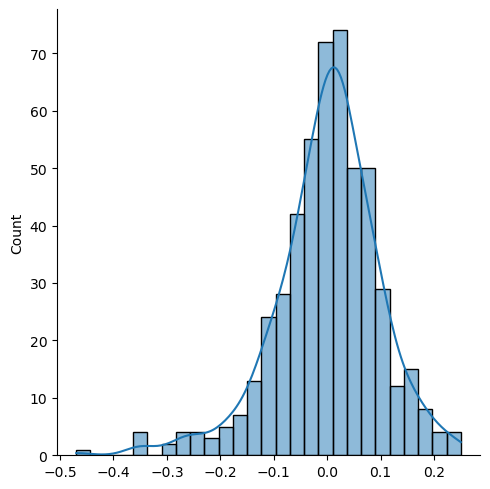

In [61]:
y_train_pred = ols_4.predict(X_train_sm)

residual = y_train -  y_train_pred
sns.displot(residual, kde=True)
plt.show()

* The residual error terms are normally distributed

In [62]:
#prepare test dataframe by splitting into target variable and test features
y_test = bike_rental_test_df.pop('cnt')
X_test = bike_rental_test_df

In [63]:
X_test_sm = sm.add_constant(X_test[feature_columns])
y_test_pred = ols_4.predict(X_test_sm)

In [64]:
#r2 score computation
r2_test_score = r2_score(y_test, y_test_pred) 
r2_test_score

0.7609720098582939

# Automatic Feature Selection

* RFE based initial feature selection followed by manual pruning

In [65]:
#set up a sklearn linear Regression estimator for RFE
lr = LinearRegression()
lr.fit(X_train, y_train)

rfe = RFE(estimator=lr, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [66]:
# obtain ranked feature by RFE
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('mnth', False, 5),
 ('holiday', False, 4),
 ('workingday', False, 2),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 3),
 ('winter', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 10),
 ('Sun', False, 9),
 ('Thurs', False, 7),
 ('Tues', False, 6),
 ('Wed', False, 8),
 ('Light_Rain_Snow', True, 1),
 ('clear_parlty_cloudy', True, 1)]

In [67]:
relevant_columns = X_train.columns[rfe.support_]
relevant_columns = list(relevant_columns)

In [68]:
X_train_sm = sm.add_constant(X_train[relevant_columns])
sm_mlr_5 = sm.OLS(y_train, X_train_sm)
ols_5 = sm_mlr_5.fit()

In [69]:
relevant_columns

['yr',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'spring',
 'winter',
 'Mon',
 'Light_Rain_Snow',
 'clear_parlty_cloudy']

In [70]:
ols_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     243.2
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          1.14e-184
Time:                        20:29:17   Log-Likelihood:                 465.78
No. Observations:                 510   AIC:                            -909.6
Df Residuals:                     499   BIC:                            -863.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1976      0.038      5.206      0.000       0.123       0.272
yr                      0.2558      0.009     28.656      0.000       0.238       0.273
temp                    0.3521      0.137      2.564      0.011       0.082       0.622
atemp                   0.1257      0.142      0.883      0.378      -0.154       0.406
hum                    -0.0981      0.040     -2.460      0.014      -0.176      -0.020
windspeed              -0.1087      0.025     -4.367      0.000      -0.158      -0.060
spring                 -0.1253      0.016     -7.953      0.000      -0.156      -0.094
winter                  0.0642      0.013      4.899      0.000       0.038       0.090
Mon                     0.0216      0.012      1.729      0.084      -0.003       0.046
Light_Rain_Snow        -0.1772      0.027     -6.640      0.000      -0.230      -0.125
clear_parlty_cloudy     0.0611      0.011      5.328      0.000       0.039       0.084
==============================================================================
Omnibus:                       82.699   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.292
Skew:                          -0.881   Prob(JB):                     5.23e-39
Kurtosis:                       5.279   Cond. No.                         78.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'atemp' and 'Mon' categorical value shows high pValue > 0.05

In [71]:
X = X_train[relevant_columns]
vif = pd.DataFrame()
vif["predictors"] = X.columns
vif["vif"] = [variance_inflation_factor(X.values, idx) for idx in range(X.shape[1])]
vif["vif"] = round(vif["vif"],2)
vif.sort_values(by="vif", ascending=False)

,predictors,vif
2,atemp,354.51
1,temp,351.20
3,hum,15.41
4,windspeed,4.27
9,clear_parlty_cloudy,3.33
5,spring,2.61
0,yr,2.08
6,winter,2.04
7,Mon,1.17
8,Light_Rain_Snow,1.17


In [72]:
relevant_columns.remove('Mon')
relevant_columns.remove('atemp')

In [73]:
X_train_sm = sm.add_constant(X_train[relevant_columns])
sm_mlr_6 = sm.OLS(y_train, X_train_sm)
ols_6 = sm_mlr_6.fit()

In [74]:
ols_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     302.5
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          2.44e-186
Time:                        20:29:33   Log-Likelihood:                 463.86
No. Observations:                 510   AIC:                            -909.7
Df Residuals:                     501   BIC:                            -871.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2038      0.038      5.381      0.000       0.129       0.278
yr                      0.2555      0.009     28.584      0.000       0.238       0.273
temp                    0.4684      0.030     15.706      0.000       0.410       0.527
hum                    -0.0975      0.040     -2.447      0.015      -0.176      -0.019
windspeed              -0.1099      0.025     -4.440      0.000      -0.159      -0.061
spring                 -0.1268      0.016     -8.040      0.000      -0.158      -0.096
winter                  0.0643      0.013      4.916      0.000       0.039       0.090
Light_Rain_Snow        -0.1762      0.027     -6.620      0.000      -0.228      -0.124
clear_parlty_cloudy     0.0619      0.011      5.396      0.000       0.039       0.084
==============================================================================
Omnibus:                       75.497   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.208
Skew:                          -0.814   Prob(JB):                     2.68e-35
Kurtosis:                       5.200   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
X = X_train[relevant_columns]
vif = pd.DataFrame()
vif["predictors"] = X.columns
vif["vif"] = [variance_inflation_factor(X.values, idx) for idx in range(X.shape[1])]
vif["vif"] = round(vif["vif"],2)
vif.sort_values(by="vif", ascending=False)

,predictors,vif
2,hum,15.05
1,temp,14.26
3,windspeed,4.18
7,clear_parlty_cloudy,3.29
4,spring,2.61
0,yr,2.08
5,winter,2.03
6,Light_Rain_Snow,1.16


'hum' & 'temp' feature shows high VIF manually elemenating them one by one

In [76]:
relevant_columns.remove('hum')
X_train_sm = sm.add_constant(X_train[relevant_columns])
sm_mlr_7 = sm.OLS(y_train, X_train_sm)
ols_7 = sm_mlr_7.fit()

In [77]:
ols_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     341.4
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          2.49e-186
Time:                        20:29:37   Log-Likelihood:                 460.83
No. Observations:                 510   AIC:                            -905.7
Df Residuals:                     502   BIC:                            -871.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1328      0.024      5.431      0.000       0.085       0.181
yr                      0.2590      0.009     29.220      0.000       0.242       0.276
temp                    0.4530      0.029     15.462      0.000       0.395       0.511
windspeed              -0.0927      0.024     -3.887      0.000      -0.140      -0.046
spring                 -0.1279      0.016     -8.075      0.000      -0.159      -0.097
winter                  0.0601      0.013      4.610      0.000       0.034       0.086
Light_Rain_Snow        -0.1887      0.026     -7.190      0.000      -0.240      -0.137
clear_parlty_cloudy     0.0775      0.010      8.086      0.000       0.059       0.096
==============================================================================
Omnibus:                       71.892   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.028
Skew:                          -0.790   Prob(JB):                     1.18e-32
Kurtosis:                       5.103   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
X = X_train[relevant_columns]
vif = pd.DataFrame()
vif["predictors"] = X.columns
vif["vif"] = [variance_inflation_factor(X.values, idx) for idx in range(X.shape[1])]
vif["vif"] = round(vif["vif"],2)
vif.sort_values(by="vif", ascending=False)

,predictors,vif
1,temp,4.45
2,windspeed,4.05
6,clear_parlty_cloudy,3.04
0,yr,2.07
3,spring,1.71
4,winter,1.36
5,Light_Rain_Snow,1.12


### We arrive at the relevant feature combination via RFE and Manual Elimination based on (pvalue and VIF) 

In [79]:
relevant_columns

['yr',
 'temp',
 'windspeed',
 'spring',
 'winter',
 'Light_Rain_Snow',
 'clear_parlty_cloudy']

## Residual Analysis

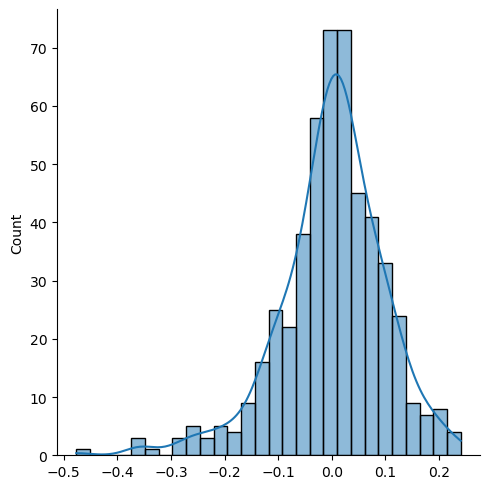

In [80]:
y_train_pred = ols_7.predict(X_train_sm)
residual = y_train - y_train_pred
sns.displot(residual, kde=True)
plt.show()

* The residual error terms are normally distributed

In [81]:
X_test_sm = sm.add_constant(X_test[relevant_columns])
y_test_pred = ols_7.predict(X_test_sm)

r2Score = r2_score(y_test, y_test_pred)
n,p = X_test.shape
adjusted_r2  = 1 - (((1-r2Score) * (n-1))/(n-p-1))

print (r2Score, adjusted_r2)

0.7608704528265458 0.7380389885235525


Text(0, 0.5, 'y_pred')

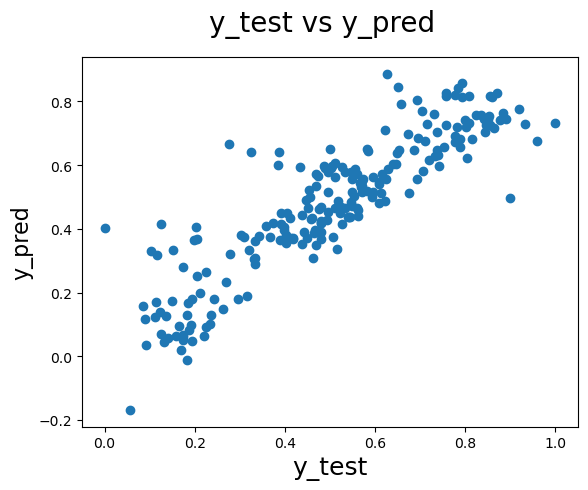

In [82]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label


# Model Building

In [83]:
# fit a sklearn linear regression model
lm = LinearRegression().fit(X_train[relevant_columns],y_train)

In [84]:
r2Score_test = r2_score(y_test, lm.predict(X_test[relevant_columns]))

In [85]:
residual = (y_train - lm.predict(X_train[relevant_columns]))
r2Score_train = r2_score(y_train, lm.predict(X_train[relevant_columns]))

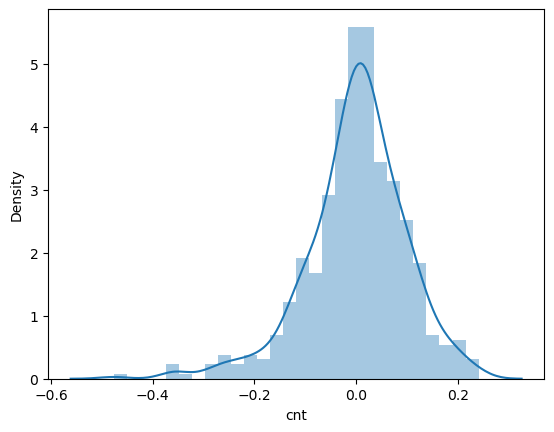

In [86]:
sns.distplot(residual, kde=True)
plt.show()

Q-Q plot

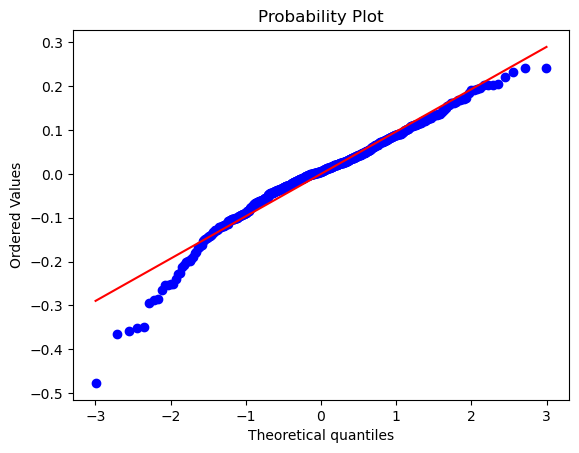

In [110]:
fig, ax = plt.subplots()
res = stats.probplot(residual, plot=plt)
plt.show()

In [88]:
r2Score_test

0.760870452826546

In [89]:
r2Score_train

0.8264168396559474

## Summary

Which variables are significant in predicting the demand for shared bikes?

The relevant feature columns describing the demand are.

In [90]:
relevant_columns

['yr',
 'temp',
 'windspeed',
 'spring',
 'winter',
 'Light_Rain_Snow',
 'clear_parlty_cloudy']

How well those variables describe the bike demands?

r2 score summarized below

#### R2 Score on test data

In [91]:
r2Score_test

0.760870452826546

adjusted r2 score

In [92]:
n,p = X_test[relevant_columns].shape

In [93]:
adjusted_r2  = 1 - (((1-r2Score_test) * (n-1))/(n-p-1))

In [94]:
adjusted_r2

0.7529372451004124

r2Score on train data

In [95]:
r2Score_train

0.8264168396559474